In [1]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策


Mounted at /content/drive


## 多変量解析

note5-1で保存した多項式回帰の正解データおよび各種変数をJSONファイルから読み込む。<BR>
ここでは、M_truth=4, N=100を前提にしている。

{'M_truth': 4, 'N': 100, 'w_truth_m': [0.6999999999999997, -1.0, 0.09999999999999964, 0.3999999999999997], 'sigma': 1.5, 'lmd': 0.4444444444444444, 'x_line': [-3.0, -2.99, -2.9800000000000004, -2.9700000000000006, -2.960000000000001, -2.950000000000001, -2.9400000000000013, -2.9300000000000015, -2.9200000000000017, -2.910000000000002, -2.900000000000002, -2.8900000000000023, -2.8800000000000026, -2.8700000000000028, -2.860000000000003, -2.850000000000003, -2.8400000000000034, -2.8300000000000036, -2.820000000000004, -2.810000000000004, -2.8000000000000043, -2.7900000000000045, -2.7800000000000047, -2.770000000000005, -2.760000000000005, -2.7500000000000053, -2.7400000000000055, -2.7300000000000058, -2.720000000000006, -2.710000000000006, -2.7000000000000064, -2.6900000000000066, -2.680000000000007, -2.670000000000007, -2.6600000000000072, -2.6500000000000075, -2.6400000000000077, -2.630000000000008, -2.620000000000008, -2.6100000000000083, -2.6000000000000085, -2.5900000000000087, -2.5

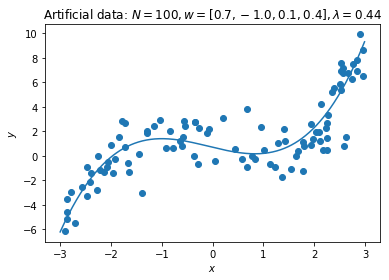

In [3]:
import json
with open(output_dir + 'note5-1_output.json') as json_file:
   json_data = json.load(json_file) # JSONファイルを辞書型の変数として読み出す

print (json_data)

# 個別の変数に戻す
M_truth = json_data['M_truth']
N = json_data['N']

w_truth_m = np.array(json_data['w_truth_m'])
sigma = json_data['sigma']
lmd = json_data['lmd']

# 真のモデルのデータ
x_line = np.array(json_data['x_line'])
y_line = np.array(json_data['y_line'])

# 真のデータにノイズを加えた観測データ
x = np.array(json_data['x_n']) # 説明変数 note5-1 では x_n でしたがでしたが x にしました。
y = np.array(json_data['y_n']) # 目的変数 note5-1 では y_n でしたがでしたが y にしました。

# 保存データから読み出した変数の型が元にもどっているかを確認
print (type(M_truth), type(N), type(w_truth_m), type(sigma), type(lmd), type(x_line), type(y_line), type(x), type(y))

# 観測データの散布図 教科書 図3.7を作成
fig = plt.figure()
plt.scatter(x, y) # ノイズを加えた観測データ
plt.plot(x_line, y_line) # 真のモデル
plt.title('Artificial data: $N=' + str(N) + ', w=[' + ', '.join([str(w) for w in np.round(w_truth_m, 2).flatten()]) + ']' + ', \lambda=' + str(np.round(lmd, 2)) + '$') #w の要素数が次元数数Mにあたることに注意
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()


In [4]:
# 学習データと予測データにデータを分割するために、train_test_split という関数が便利です。
from sklearn.model_selection import train_test_split
# sklearn の cross_validation というのは廃止されたので使えません。

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) # 予測データをを2割にしました

# X軸が昇順にならんで「いない」ことが曲者。計算上は問題ないが可視化上めんどくさい
print (x_train)
print (y_train)
print ("---")
print (x_test)
print (y_test)

[ 2.12  2.84  2.51  2.56  2.56 -2.7   0.83 -0.07  0.44  2.75  2.67  2.85
 -1.3   1.42 -1.72  2.91 -0.11 -2.86  1.12 -2.86 -2.05 -1.66  2.26 -2.91
 -2.79 -2.26 -0.84 -1.78 -1.45  0.21 -2.27  0.68  2.96  1.68 -0.34 -0.65
  2.24 -2.21  1.54  0.96  1.93 -0.59 -1.3  -2.48 -0.35 -2.87  2.52  1.77
  1.64 -0.26 -1.16 -1.64  2.59  1.98  2.62 -1.39  1.37  1.79 -0.55  2.35
  2.28 -1.99 -1.92 -0.91 -0.78 -0.61 -1.84 -2.48  2.09  2.53  0.78 -2.58
  2.52  1.28  2.96 -2.14  1.22 -2.08  0.57  2.03]
[ 1.21715882e+00  6.88773990e+00  5.89629507e+00  6.77363710e+00
  7.18628122e+00 -5.46608334e+00 -2.19755469e-01  2.19870526e+00
  5.59993204e-01  6.24435649e+00  6.78079762e+00  7.81558080e+00
  1.90106386e+00  1.20927026e+00  2.65896389e+00  9.91241168e+00
  1.83972195e+00 -3.55154971e+00 -6.64161691e-01 -4.55461872e+00
 -5.18277533e-01 -5.72494077e-01  2.65891056e+00 -6.13871275e+00
 -2.92877911e+00 -5.18595836e-02  2.02154657e+00  2.81372260e+00
  1.53195999e-01  3.04571206e+00 -2.77229623e+00 -9.10223

In [5]:
# そこで、後のグラフ表示のためx座標を昇順にしたときの順番で、y座標を並び替えておく
# 参考 https://tech-market.org/mnist-sort/

#ソート用のインデックスを取得
sorted_index1 = np.argsort(x_train)
#ソートする
y_train = y_train[sorted_index1]
x_train = x_train[sorted_index1]

#ソート用のインデックスを取得
sorted_index2 = np.argsort(x_test)
#ソートする
y_test = y_test[sorted_index2]
x_test = x_test[sorted_index2]

# x座標を昇順にされ、かつ、そのxが並び替えられた順番で、y座標が並んでいる(昇順とはかぎらない)ことを確認
print (x_train)
print (y_train)
print ("--")
print (x_test)
print (y_test)

[-2.91 -2.87 -2.86 -2.86 -2.79 -2.7  -2.58 -2.48 -2.48 -2.27 -2.26 -2.21
 -2.14 -2.08 -2.05 -1.99 -1.92 -1.84 -1.78 -1.72 -1.66 -1.64 -1.45 -1.39
 -1.3  -1.3  -1.16 -0.91 -0.84 -0.78 -0.65 -0.61 -0.59 -0.55 -0.35 -0.34
 -0.26 -0.11 -0.07  0.21  0.44  0.57  0.68  0.78  0.83  0.96  1.12  1.22
  1.28  1.37  1.42  1.54  1.64  1.68  1.77  1.79  1.93  1.98  2.03  2.09
  2.12  2.24  2.26  2.28  2.35  2.51  2.52  2.52  2.53  2.56  2.56  2.59
  2.62  2.67  2.75  2.84  2.85  2.91  2.96  2.96]
[-6.13871275e+00 -5.18510437e+00 -3.55154971e+00 -4.55461872e+00
 -2.92877911e+00 -5.46608334e+00 -2.56255350e+00 -3.30522065e+00
 -9.12117262e-01 -2.77229623e+00 -5.18595836e-02 -1.12534440e+00
 -1.28792269e+00 -9.16650494e-01 -5.18277533e-01  9.18394153e-01
 -2.89565981e-01  1.53479982e+00  2.81372260e+00  2.65896389e+00
 -5.72494077e-01 -1.29863562e+00  1.53195999e-01 -3.00354573e+00
  1.90106386e+00  2.05445522e+00  2.40489852e+00  6.49608139e-01
  2.02154657e+00  6.41941202e-01  1.20027089e+00  7.71535